# Attantion!
This is modified file. There are some insrerts in the document.
To run correctly, you need to install the elkan module.

Use the command:
pip install dir

dir is the directory of source files and this document.

# Problem statement

Write native Python extension module, say `elkan`, that implements iterative solution to k-means problem using algorithm from 
Charles Elkan, "Using the triangle inequality to accelerate k-means." Article PDF is available via https://www.aaai.org/Papers/ICML/2003/ICML03-022.pdf

The native extension should expose a C/C++ implementation of iterative algorithm. Its inputs are an $(n,p)$ matrix of $n$ points from $\mathbb{R}^p$, number of clusters $n_c$, a $(c,p)$ matrix of coordinates for starting center of clusters, the convergence threshold $\epsilon$, and a maximal number of iterations.

Native extension should allow for matrix inputs to be NumPy arrays. All inputs coordinates are expected to be in double precision.

The native extension should return a tuple with coordinate centers as an matrix of dimensions $(c,p)$ and a vector of length $n$ with label assignments for each input datapoint, and the number of iterations performed.

You may use SWIG or Cython to generate the native extension, process arguments, call your C/C++ implementation, and return the result back to Python.

Compare performance of your implementation with performance of a reference implementation.

# An example of the test

In [48]:
import elkan # import your module

In [49]:
import numpy as np  # import numpy

In [50]:
def cuboidal_p(idx, p):
    """Generate points of cuboidal level surfaces by its index"""
    per_level = 2 ** p
    radius = ((idx // per_level) + 1)
    rem = idx % per_level
    digits = [ -radius ] * p
    i = -1
    while(rem > 0):
        digits[-i] = radius * (2 * (rem % 2) - 1)
        rem = rem // 2
        i += 1
    return np.asarray(digits)

In [51]:
# generate n points in p-dimensional space with given clusters
(n, p, cl) = (100, 4, 5)
disps = np.array([ cuboidal_p(idx, p) for idx in range(cl)])

In [52]:
# assign points to clusters randomly
np.random.seed(1234567)
cl_idx = np.random.choice(cl, size=n)
points = np.random.rand(n, p) + np.take(disps, cl_idx, axis=0)

In [53]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [54]:
# embed p-dimensional points onto a plane while preserving relative distances for viz. purposes.
(x, y) = TSNE().fit_transform(points).T

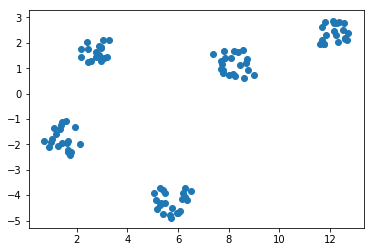

In [55]:
plt.scatter(x, y)
plt.show()

K-means gives only the local minimum. The result and the execution time depend strongly on the initial conditions. That's why we need to give the same initial cluster centers. An easy way to get them is to take points from input data.

In [56]:
sPoints = points[:cl,:]

We also need threshold and maxIterationsCount parameters. An explanation of the threshold is given at the end of this document.

In [57]:
# threshold = 2.22507e-308
threshold = 1e-16
maxIterationsCount = 300

Import "time" to detect the execution tome.

In [58]:
import time

Use scikit-learn to compute clusters, and visualize that they agree with data

In [59]:
from sklearn.cluster import KMeans

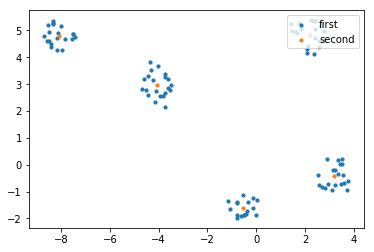

In [60]:
elkanTime = time.time()
elkan_km = KMeans(algorithm='elkan', init=sPoints, n_clusters=cl, n_init=1, tol=threshold,
            max_iter=maxIterationsCount).fit(points)
elkanTime = time.time() - elkanTime

(xx, yy) = TSNE().fit_transform(np.vstack((points, elkan_km.cluster_centers_))).T

plt.scatter(xx[:n], yy[:n], s=10, marker="o", label='first')
plt.scatter(xx[n:], yy[n:], s=10, marker="o", label='second')
plt.legend(loc='upper right');
plt.show()


Your example should be able to replicate this behavior.

Now we replicate this behavior for the full algorithm and our implementation of the Elkan algorithm. Then compare the results and the execution time.

In [61]:
fullTime = time.time()
full_km = KMeans(algorithm='full', init=sPoints, n_clusters=cl, n_init=1, tol=threshold,
            max_iter=maxIterationsCount).fit(points)
fullTime = time.time() - fullTime

myTime = time.time()
(centers, pLabels, iCount, isEmptyCluster) = elkan.execute(p, n, points, cl, sPoints,
                                                           threshold, maxIterationsCount)
myTime = time.time() - myTime

print('Are the cluster centers in our algorithm and in the elkan the same?',
      np.allclose(elkan_km.cluster_centers_, centers))
print('Are the labels in our algorithm and in the elkan the same?',
      np.array_equal(elkan_km.labels_, pLabels))
print('Are the cluster centers in our algorithm and in the full the same?',
      np.allclose(full_km.cluster_centers_, centers))
print('Are the labels in our algorithm and in the full the same?',
      np.array_equal(full_km.labels_, pLabels))

print(myTime ,'myTime')
print(elkanTime ,'elkanTime')
print(fullTime ,'fullTime')

Are the cluster centers in our algorithm and in the elkan the same? True
Are the labels in our algorithm and in the elkan the same? True
Are the cluster centers in our algorithm and in the full the same? True
Are the labels in our algorithm and in the full the same? True
0.0010001659393310547 myTime
0.0020003318786621094 elkanTime
0.003999948501586914 fullTime


# Changing the parameters in the range
Now we try to execute algorithms with different parameters and compare the results. To get results when the Elkan algorithm is faster than the full algorithm, we need to select large parameters. But with large parameters, the calculations take a long time, be prepared to wait. In the example below, the parameters are not large.

In [45]:
myTimeTotal = 0.0
elkanTimeTotal = 0.0
fullTimeTotal = 0.0
for i_n in range(100, 600, 100):
    for i_p in range(4, 20, 5):
        for i_cl in range(5, i_n, 50):
            (n, p, cl) = (i_n, i_p, i_cl)
            disps = np.array([ cuboidal_p(idx, p) for idx in range(cl)])
            np.random.seed(1234567)
            cl_idx = np.random.choice(cl, size=n)
            points = np.random.rand(n, p) + np.take(disps, cl_idx, axis=0)
            sPoints = points[:cl,:]

            myTime = time.time()
            (centers, pLabels, iCount, isEmptyCluster) = elkan.execute(p, n, points, cl, sPoints,
                                                                       threshold, maxIterationsCount)
            myTime = time.time() - myTime
            print(n, p, cl, isEmptyCluster)
            # We dont know what is the algorithm for empty clusters is used in sklearn
            # without the same algorithm we will get different results and execution time
            if(not(isEmptyCluster)):
                elkanTime = time.time()
                elkan_km = KMeans(algorithm='elkan', init=sPoints, n_clusters=cl,
                                  n_init=1, tol=threshold, max_iter=maxIterationsCount,
                                  precompute_distances=False, n_jobs=1).fit(points)
                elkanTime = time.time() - elkanTime

                fullTime = time.time()
                full_km = KMeans(algorithm='full', init=sPoints, n_clusters=cl,
                                 n_init=1, tol=threshold, max_iter=maxIterationsCount,
                                 precompute_distances=False, n_jobs=1).fit(points)
                fullTime = time.time() - fullTime
                # print(myTime, 'myTime')
                # print(elkanTime, 'elkanTime')
                # print(fullTime, 'fullTime')
                
                myTimeTotal = myTimeTotal + myTime
                elkanTimeTotal = elkanTimeTotal + elkanTime
                fullTimeTotal = fullTimeTotal + fullTime
                
                if(not(np.allclose(elkan_km.cluster_centers_, centers)) or
                  not(np.array_equal(elkan_km.labels_, pLabels)) or
                  not(np.allclose(full_km.cluster_centers_, centers)) or
                  not(np.array_equal(full_km.labels_, pLabels))
                  ):
                    print('Error on values n =', n, 'p =', p, 'cl =', cl)
                    print('Are the cluster centers in our algorithm and in the elkan the same?',
                          np.allclose(elkan_km.cluster_centers_, centers))
                    print('Are the labels in our algorithm and in the elkan the same?',
                          np.array_equal(elkan_km.labels_, pLabels))
                    print('Are the cluster centers in our algorithm and in the full the same?',
                          np.allclose(full_km.cluster_centers_, centers))
                    print('Are the labels in our algorithm and in the full the same?',
                          np.array_equal(full_km.labels_, pLabels))
                    
print('-----------------------------------------------')
print(myTimeTotal, 'myTimeTotal')
print(elkanTimeTotal, 'elkanTimeTotal')
print(fullTimeTotal, 'fullTimeTotal')
print('-----------------------------------------------')

100 4 5 False
100 4 55 False
100 9 5 False
100 9 55 False
100 14 5 False
100 14 55 False
100 19 5 False
100 19 55 False
200 4 5 False
200 4 55 False
200 4 105 False
200 4 155 False
200 9 5 False
200 9 55 False
200 9 105 False
200 9 155 False
200 14 5 False
200 14 55 False
200 14 105 False
200 14 155 False
200 19 5 False
200 19 55 False
200 19 105 False
200 19 155 False
300 4 5 False
300 4 55 False
300 4 105 True
300 4 155 False
300 4 205 False
300 4 255 False
300 9 5 False
300 9 55 False
300 9 105 False
300 9 155 False
300 9 205 False
300 9 255 False
300 14 5 False
300 14 55 False
300 14 105 False
300 14 155 False
300 14 205 False
300 14 255 False
300 19 5 False
300 19 55 False
300 19 105 False
300 19 155 False
300 19 205 False
300 19 255 False
400 4 5 False
400 4 55 False
400 4 105 False
400 4 155 False
400 4 205 False
400 4 255 False
400 4 305 False
400 4 355 False
400 9 5 False
400 9 55 False
400 9 105 False
400 9 155 False
400 9 205 False
400 9 255 False
400 9 305 False
400 9 355 F

# Tolerance issue
Tolerance (the "tol" parameter) in elkan and full algorithms is different.
The next example show it.

In [46]:
(n, p, cl) = (2000, 2, 423)
disps = np.array([ cuboidal_p(idx, p) for idx in range(cl)])
np.random.seed(1234567)
cl_idx = np.random.choice(cl, size=n)
points = np.random.rand(n, p) + np.take(disps, cl_idx, axis=0)

sPoints = points[:cl,:]
threshold = 1e-4

elkan_km = KMeans(init=sPoints, algorithm='elkan', n_clusters=cl, tol=threshold, n_init=1).fit(points)
full_km = KMeans(init=sPoints, algorithm='full', n_clusters=cl, tol=threshold, n_init=1).fit(points)

print('Are the cluster centers the same?', np.allclose(elkan_km.cluster_centers_, full_km.cluster_centers_))
print('Are the labels the same?', np.array_equal(elkan_km.labels_, full_km.labels_))

Are the cluster centers the same? False
Are the labels the same? False


If we reduce tol, the results will be the same.

In [47]:
threshold = 1e-5

elkan_km = KMeans(algorithm='elkan', init=sPoints, n_clusters=cl, tol=threshold, n_init=1).fit(points)
full_km = KMeans(algorithm='full', init=sPoints, n_clusters=cl, tol=threshold, n_init=1).fit(points)

print('Are the cluster centers the same?', np.allclose(elkan_km.cluster_centers_, full_km.cluster_centers_))
print('Are the labels the same?', np.array_equal(elkan_km.labels_, full_km.labels_))

Are the cluster centers the same? True
Are the labels the same? True


Therefore, if the results are different, the problem may be in the too big "tol" parameter. As a result, one of the algorithms stops before the other. Try to reduce the "tol" parameter.